# In this cell, we will perform Data Cleaning

In [1]:
#Import Statements
import numpy as np
import math
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [2]:
#First, we define our data loader. 
#Much of this is from HW6
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)
def prepare_and_get_loaders(validation_split, batch_size, num_workers, dir_path):
    """
    This function loads and partitions our image data.
    
    val_split: proportion of the data that will be in the validation split
    batch_size: size of batches
    num_workers: number of parallel processors 
    dir_path: directory path of the data
    """
    
    #Transforms to apply to training and test data
    data_transforms = {
        'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ]),

        'test': transforms.Compose([
            transforms.Resize((244,244)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    }
    full_dataset = datasets.ImageFolder(dir_path)
    
    m = len(full_dataset)
    val_size = int(validation_split * m)
    train_size = m - val_size
    
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_dataset = MyDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = MyDataset(val_dataset, transform=data_transforms['test'])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return train_loader, val_loader

In [3]:
def finetune(model, train_loader, val_loader, learning_rate, num_epochs, L2, momentum1, momentum2, stepsize, gamma):
    """

    Finetunes the given model on the loader data, and returns the trained model as well as the losses
    and final validation accuracy for plotting. 
    
    model: the Pytorch model
    train_loader: the loader for the training data
    val_loader: the loader for the validation data
    learning_rate: alpha, the learning rate
    num_epochs: the number of epochs to train for
    L2: the L2 regularization value
    momentum1: the first momentum value
    momentum2: the second momentum value
    stepsize: the number of epochs between lowering the learning rate
    gamma: the ratio to multiply the learning rate at each step size

    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"My Device is {device}")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2, betas = (momentum1, momentum2))
    
    scheduler = StepLR(optimizer, step_size=stepsize, gamma=gamma)

    hist = {'train': [], 'val': []} # History of training and validation losses

    for epoch in tqdm(range(num_epochs), desc = "Training Epoch: "):
        model.train() #Training mode
        total_loss = 0.0
        for inputs, labels in train_loader:
            #put stuff on device
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero optimizer
            optimizer.zero_grad()

            #get outputs + train
            outputs = model(inputs)

            #get loss and do backward
            loss = criterion(outputs, labels)
            loss.backward()

            #step
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        hist['train'].append(avg_train_loss)

        #Validation Mode Now
        model.eval()
        total_loss = 0.0

        #keep track of correct labels so we can get the val accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                #put on device
                inputs = inputs.to(device)
                labels = labels.to(device)

                #get outputs
                outputs = model(inputs)

                #get loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                #https://www.digitalocean.com/community/tutorials/pytorch-torch-max
                max_element, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_loss / len(val_loader)
        hist['val'].append(avg_val_loss)
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        scheduler.step()
    #final val accuracy
    final_val_accuracy = 100*correct/total

    return model, hist, final_val_accuracy

In [4]:
def load_model(arch, dropout, num_classes):
    """

    Loads a pretrained model, but with the final output layer removed and replaced with a randomly
    initialized output layer that will classify among the 5 buildings.

    """
    
    #select the model we want
    if arch == "resnet18": 
        model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes)) 
    elif arch == "mobile":
        model = models.mobilenet_v2(weights="MobileNet_V2_Weights.DEFAULT")
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))
    else:
        print("Incorrect model Architecture selected")
        raise
    
    return model

In [5]:
#Dataset parameters
validation_split = 0.2
batch_size = 16
num_workers = 0
dir_path = r"C:\Users\Brandon\Desktop\Classes\E208\Homework\E208_Final\Cropped_Data_400"

train_loader, val_loader = prepare_and_get_loaders(validation_split, batch_size, num_workers, dir_path)

In [6]:
#Model Parameters
arch = "resnet18"
dropout = 0.3
num_classes = 3
model = load_model(arch, dropout, num_classes)

#Finetuning Parameters
learning_rate = 0.00001
num_epochs = 5
L2 = 10**(-3)
momentum1 = 0.9
momentum2 = 0.99
stepsize = 3
gamma = 0.1
model, hist, final_val_accuracy = finetune(model,
                                          train_loader,
                                          val_loader,
                                          learning_rate,
                                          num_epochs,
                                          L2,
                                          momentum1,
                                          momentum2, 
                                          stepsize,
                                          gamma)
print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

My Device is cpu


Training Epoch:  20%|█████████████▌                                                      | 1/5 [00:27<01:48, 27.20s/it]

Epoch [1/5], Training Loss: 1.2102, Validation Loss: 1.0592, Validation Accuracy: 45.45%


Training Epoch:  40%|███████████████████████████▏                                        | 2/5 [00:54<01:21, 27.22s/it]

Epoch [2/5], Training Loss: 1.0092, Validation Loss: 0.9799, Validation Accuracy: 59.74%


Training Epoch:  60%|████████████████████████████████████████▊                           | 3/5 [01:21<00:54, 27.29s/it]

Epoch [3/5], Training Loss: 0.9521, Validation Loss: 0.9145, Validation Accuracy: 59.74%


Training Epoch:  80%|██████████████████████████████████████████████████████▍             | 4/5 [01:49<00:27, 27.39s/it]

Epoch [4/5], Training Loss: 0.8958, Validation Loss: 0.9143, Validation Accuracy: 62.34%


Training Epoch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.37s/it]

Epoch [5/5], Training Loss: 0.8434, Validation Loss: 0.9194, Validation Accuracy: 59.74%
Our final validation accuracy accuracy using the full CNN is 59.74%


In [7]:
def plot_history(hist):
    epochs = range(1, len(hist['train']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, hist['train'], 'b', label='Training loss')
    plt.plot(epochs, hist['val'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

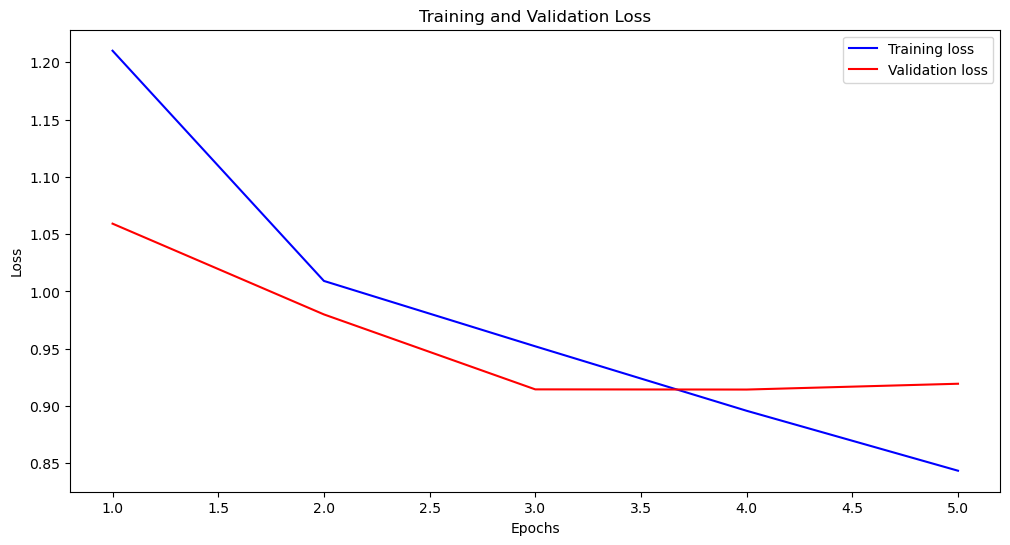

In [8]:
plot_history(hist)

In [14]:
import csv

In [22]:
class CleaningDataset(torch.utils.data.Dataset): #new dataset that also returns the path to the image
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        img_path = self.subset.imgs[index][0]  
        if self.transform:
            x = self.transform(x)
        return x, y, img_path 
    def __len__(self):
        return len(self.subset)

    

def cleaning_loader(dir_path):
    """
    This function makes our cleaning data loader, and we also need the class names for manual relabelling

    dir_path: directory path of the data
    """
    
    #Loading transform
    data_transforms = {
        'load': transforms.Compose([
            transforms.Resize((244,244)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    }
    full_dataset = datasets.ImageFolder(dir_path)
    class_names = full_dataset.classes
    
    load_dataset = CleaningDataset(full_dataset, transform=data_transforms['load'])
    
    clean_loader = torch.utils.data.DataLoader(load_dataset, shuffle=False, num_workers=0)
    
    return clean_loader, class_names



def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    tensor = tensor * std[:, None, None] + mean[:, None, None]
    return tensor.clamp(0, 1) #have to be between 0 and 1



def get_misclassified_images(loader, model, class_names, confidence_threshold=0.1):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, true_labels, paths in tqdm(iter(loader), desc="Evaluating"):
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, predicted_labels = torch.max(probabilities, dim=1)

            for i in range(len(images)):
                if predicted_labels[i] != true_labels[i] and max_probs[i] > confidence_threshold:
                    misclassified.append({
                        'image': images[i],
                        'true_label': true_labels[i],
                        'predicted_label': predicted_labels[i],
                        'confidence': max_probs[i].item(),
                        'path': paths[i]
                    })

    # Sort in descending order cuz we wanna show the worst classified first
    misclassified.sort(key=lambda x: x['confidence'], reverse=True)
    return misclassified

def display_misclassified_images(misclassified_list, class_names, output_csv):
    # Initialize a dictionary to store misclassification counts
    misclassification_counts = {name: {other: 0 for other in class_names} for name in class_names}

    #Count misclassifications
    for item in misclassified_list:
        true_label_name = class_names[item['true_label']]
        predicted_label_name = class_names[item['predicted_label']]
        misclassification_counts[true_label_name][predicted_label_name] += 1

    #Print total number of misclassified images
    total_misclassified = len(misclassified_list)
    print(f"Total Misclassified Images: {total_misclassified}")

    # Print misclassification details
    for true_label, predictions in misclassification_counts.items():
        for predicted_label, count in predictions.items():
            if true_label != predicted_label and count > 0:
                print(f"True Label '{true_label}' predicted as '{predicted_label}': {count} times")

    # Create or open the CSV file
    with open(output_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Filename', 'Original Label', 'Final Label'])

        #Displaying loop - USER INPUT FOR MODIFYING CSV
        for item in misclassified_list:
            img = unnormalize(item['image']).permute(1, 2, 0) #from hw6
            plt.imshow(img)
            plt.title(f"Filename: {item['path']}\nPredicted: {class_names[item['predicted_label']]}, Actual: {class_names[item['true_label']]}, Confidence: {item['confidence']:.2f}")
            plt.show()

            #We determine if relabelling
            response = input("Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): ").strip().lower()
            final_label = item['true_label']
            if response == 'y':
                final_label = item['predicted_label']
            elif response == 'c':
                # Show available class names and take input
                print("Available classes: ", class_names)
                custom_label = input("Enter the custom label name: ").strip()
                if custom_label in class_names:
                    final_label = class_names.index(custom_label)
                else:
                    print("Invalid label name. Keeping the original label.")

            # Write to CSV
            writer.writerow([item['path'], class_names[item['true_label']], class_names[final_label]])
        

        


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 385/385 [00:24<00:00, 16.00it/s]


Total Misclassified Images: 95
True Label 'Algae' predicted as 'Hard Coral': 20 times
True Label 'Algae' predicted as 'Soft Coral': 30 times
True Label 'Hard Coral' predicted as 'Algae': 9 times
True Label 'Hard Coral' predicted as 'Soft Coral': 13 times
True Label 'Soft Coral' predicted as 'Algae': 6 times
True Label 'Soft Coral' predicted as 'Hard Coral': 17 times


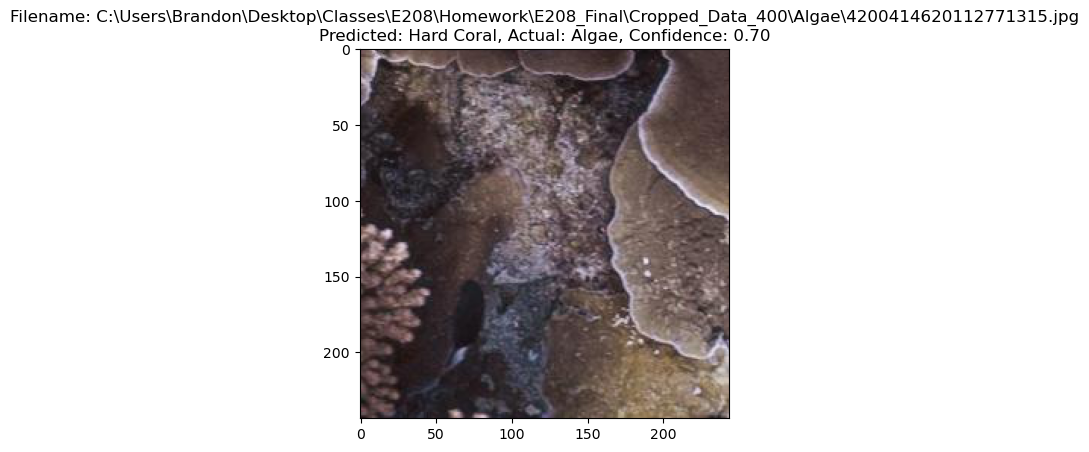

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): y


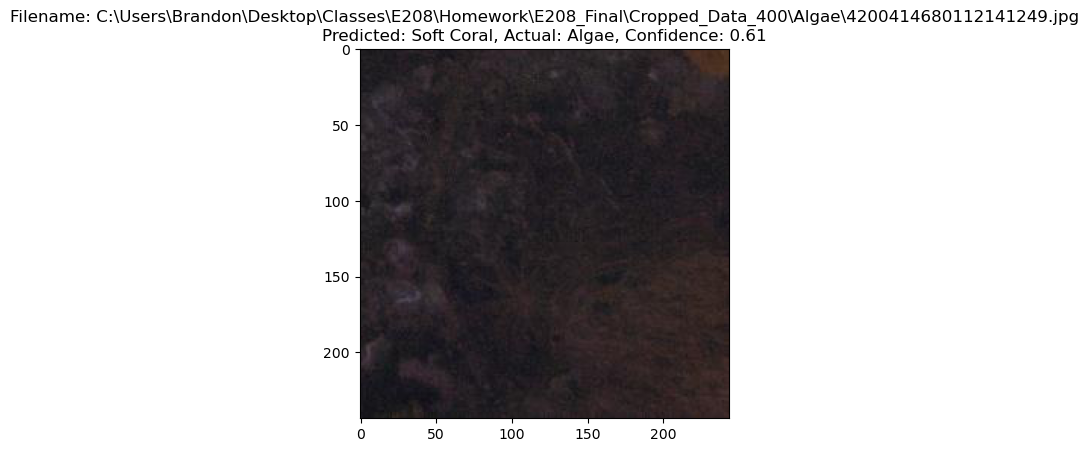

KeyboardInterrupt: Interrupted by user

In [24]:
clean_loader, class_names = cleaning_loader(dir_path)
misclassified_images = get_misclassified_images(clean_loader, model, class_names)
csv_name = r"\Users\Brandon\Desktop\Classes\E208\Homework\E208_Final\output_labelling.csv"
display_misclassified_images(misclassified_images, class_names, csv_name)


Total Misclassified Images: 95
True Label 'Algae' predicted as 'Hard Coral': 20 times
True Label 'Algae' predicted as 'Soft Coral': 30 times
True Label 'Hard Coral' predicted as 'Algae': 9 times
True Label 'Hard Coral' predicted as 'Soft Coral': 13 times
True Label 'Soft Coral' predicted as 'Algae': 6 times
True Label 'Soft Coral' predicted as 'Hard Coral': 17 times


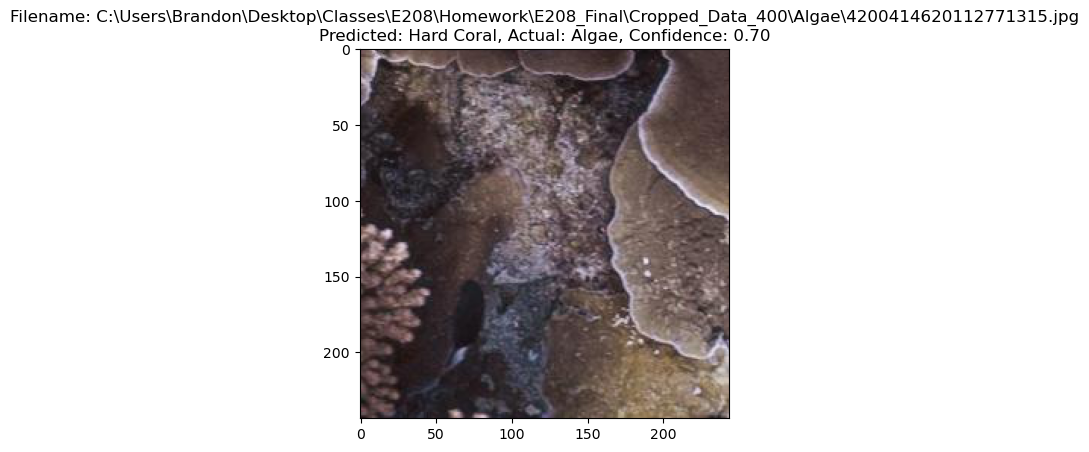

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): y


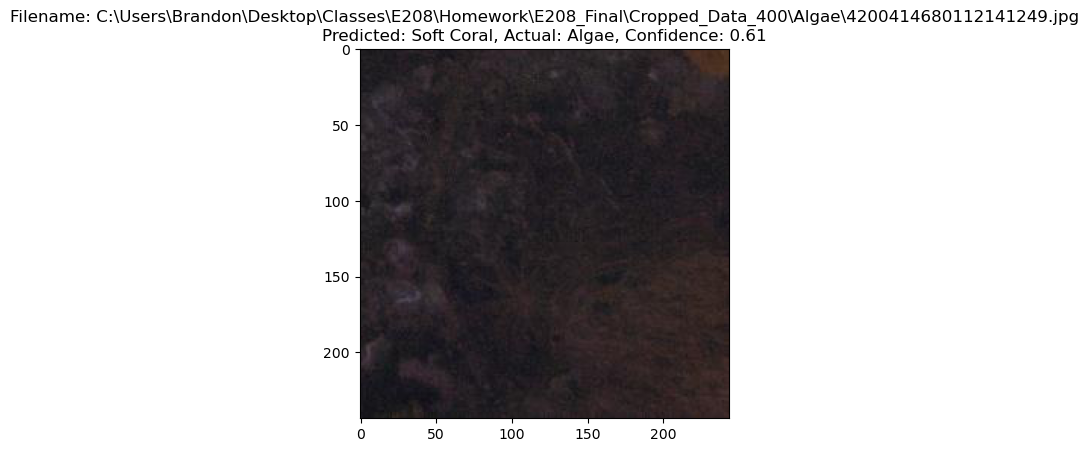

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


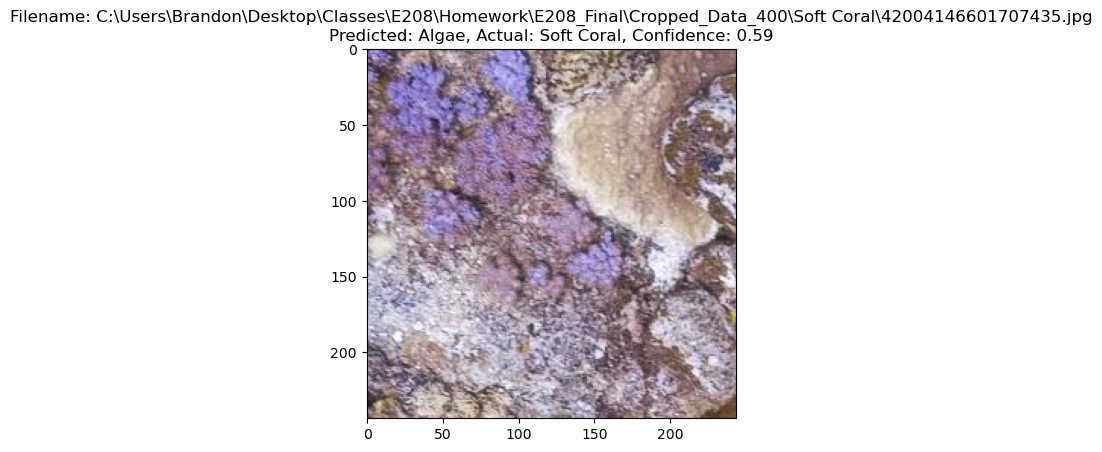

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


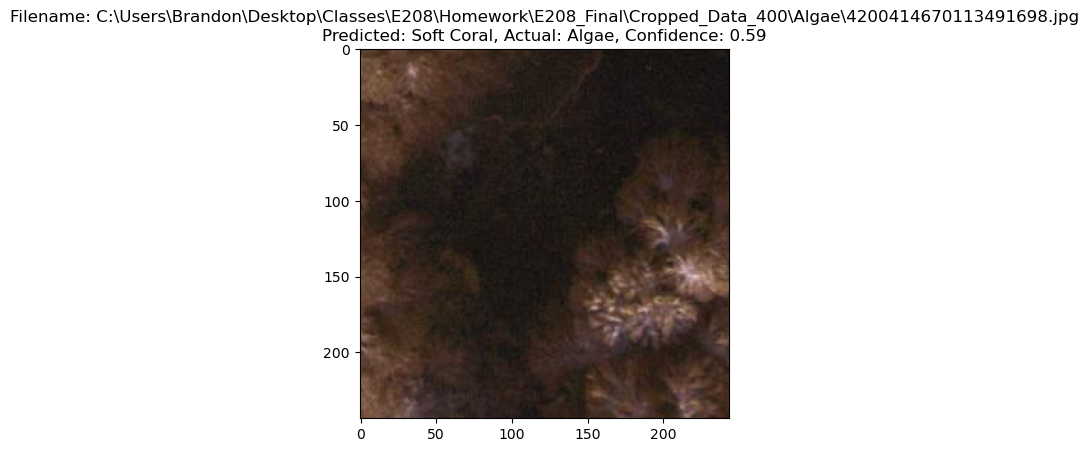

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


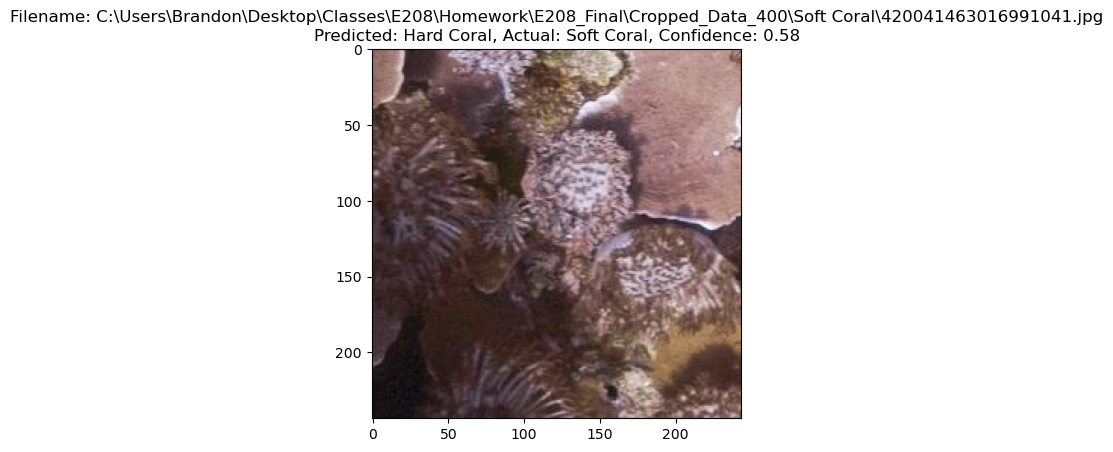

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


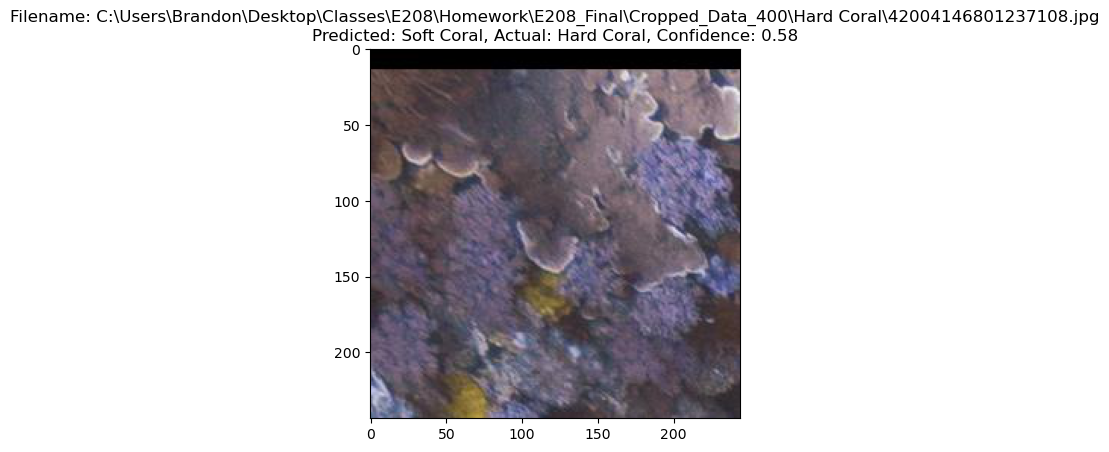

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


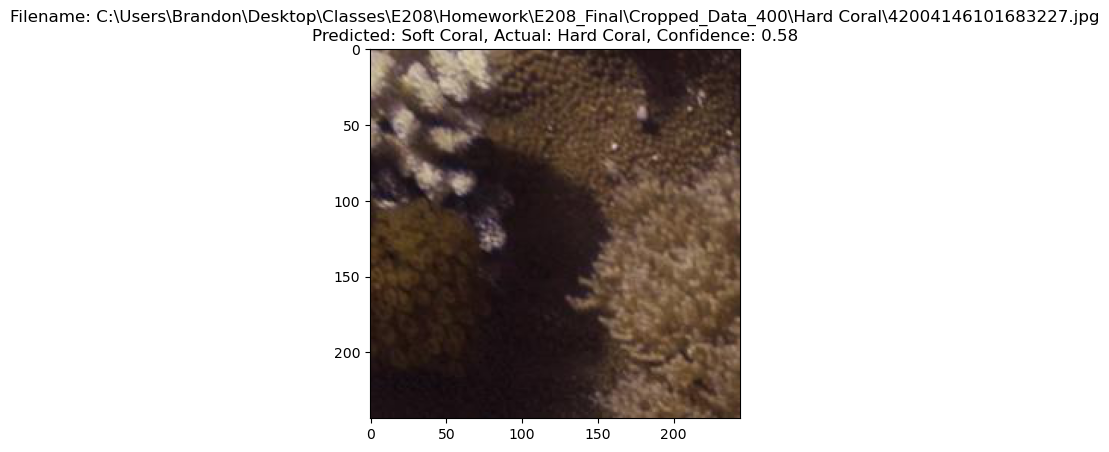

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


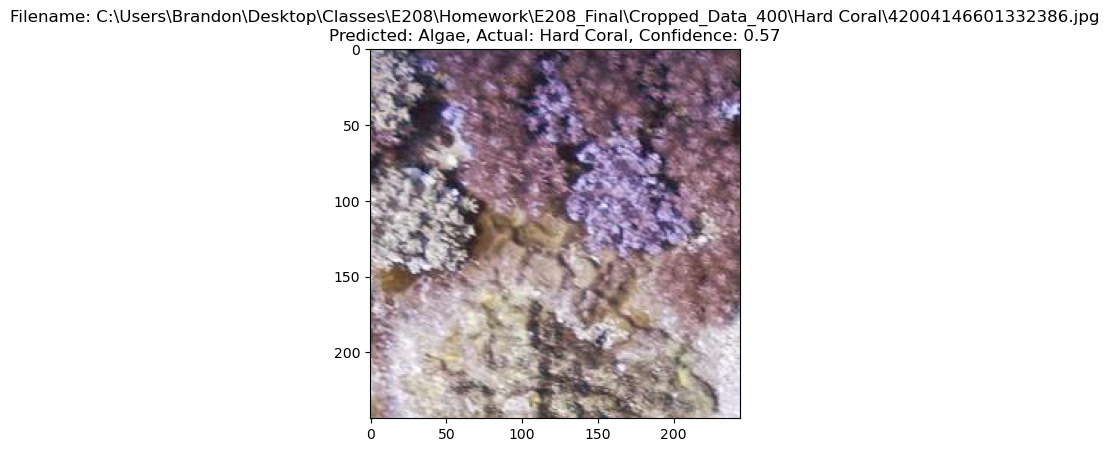

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


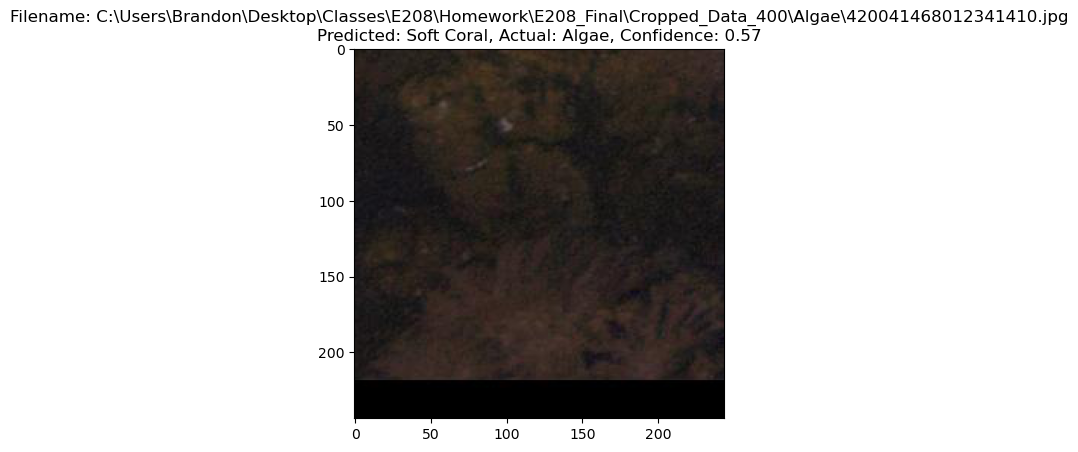

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


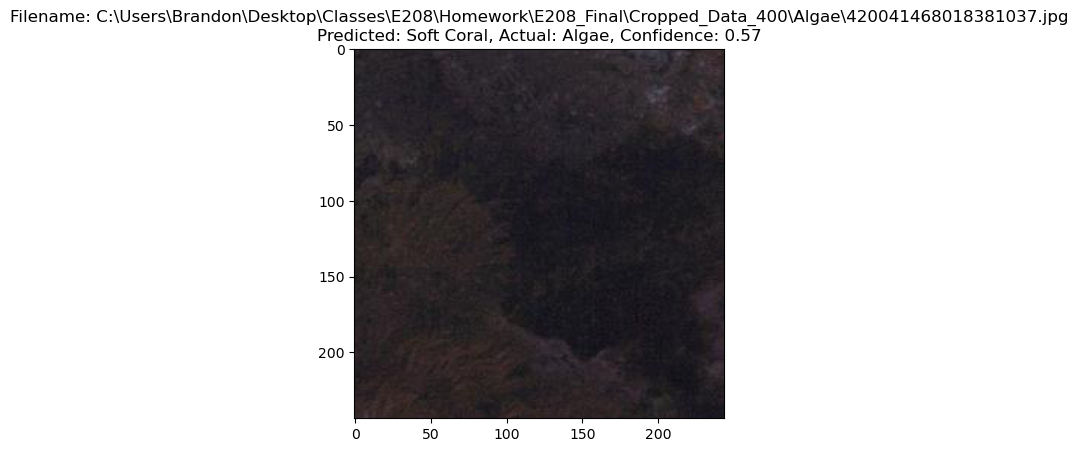

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


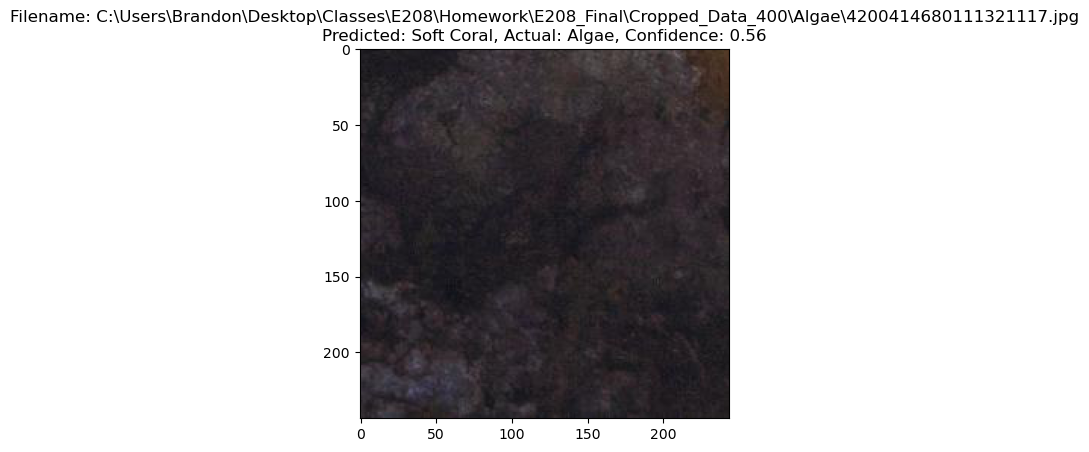

Relabel this image? [y/n/c] (y: yes, n: no, c: custom label): n


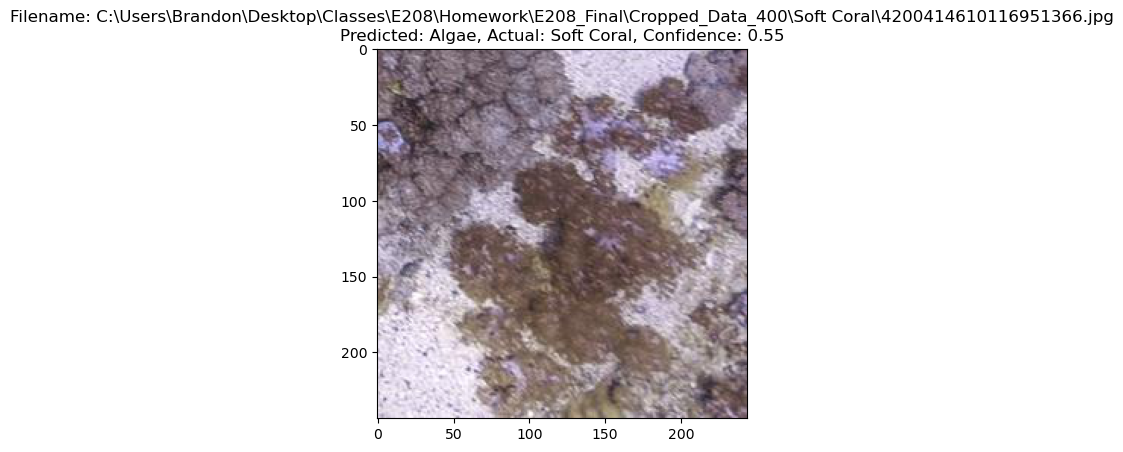

In [ ]:
display_misclassified_images(misclassified_images, class_names, csv_name)

In [ ]:
#Multilabelling could help 
#Relabelling and putting back in
#Train on more fine-grained label